# Introduction: Writing Patent Abstracts with a Recurrent Neural Network

The purpose of this notebook is to develop a recurrent neural network using LSTM cells that can generate patent abstracts. We will look at using a _word level_ recurrent neural network and _embedding_ the vocab, both with pre-trained vectors and training our own embeddings. We will train the model by feeding in as the features a long sequence of words (for example 50 words) and then using the next word as the label. Over time, the network will (hopefully) learn to predict the next word in a given sequence and we can use the model predictions to generate entirely novel patent abstracts.

## Approach 

The approach to solving this problem is:

1. Read in training data: thousands of "neural network" patents
2. Convert patents to integer sequences: `tokenization`
3. Create training dataset using next word following a sequence as label
4. Build a recurrent neural network using word embeddings and LSTM cells
5. Load in pre-trained embeddings
6. Train network to predict next word from sequence
7. Generate new abstracts by feeding network a seed sequence
8. Repeat steps 2 - 7 using pre-trained embeddings
9. Try different model architecture to see if performance improves
10. For fun, create a simple game where we must guess if the output is human or computer! 

Each of these steps is relatively simple by itself, so don't be intimidated. We'll walk through the entire process and at the end will be able to have a working application of deep learning! 

In [1]:
# Set up IPython to show all outputs from a cell
import warnings
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'

warnings.filterwarnings('ignore', category=RuntimeWarning)

RANDOM_STATE = 50
EPOCHS = 150
BATCH_SIZE = 2048
TRAINING_LENGTH = 50
TRAIN_FRACTION = 0.7
LSTM_CELLS = 64
VERBOSE = 0
SAVE_MODEL = True

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

ImportError: cannot import name 'LayerNormalization' from 'tensorflow.python.keras.layers.normalization' (C:\Users\aruni\anaconda3\lib\site-packages\tensorflow\python\keras\layers\normalization\__init__.py)

## Read in Data 

Our data consists of patent abstracts by searching for the term "neural networks" on [patentsview query](http://www.patentsview.org/querydev) web interface. The data can be downloaded in a number of formats and can include a number of patent attributes (I only kept 4). 

In [3]:
import pandas as pd
import numpy as np

# Read in data
data = pd.read_csv(
    'C:/Users/aruni/Desktop/McGill/Winter W2 Term/Intro to AI and DL/Individual_Project/rnn/neural_network_patent_query.csv', parse_dates=['patent_date'])

# Extract abstracts
original_abstracts = list(data['patent_abstract'])
len(original_abstracts)

data.head()

3522

,patent_abstract,patent_date,patent_number,patent_title
0,""" A """"Barometer"""" Neuron enhances stability in...",1996-07-09,5535303,"""""""Barometer"""" neuron for a neural network"""
1,""" This invention is a novel high-speed neural ...",1993-10-19,5255349,"""Electronic neural network for solving """"trave..."
2,An optical information processor for use as a ...,1995-01-17,5383042,3 layer liquid crystal neural network with out...
3,A method and system for intelligent control of...,2001-01-02,6169981,3-brain architecture for an intelligent decisi...
4,A method and system for intelligent control of...,2003-06-17,6581048,3-brain architecture for an intelligent decisi...


### Brief Data Exploration

This data is extremely clean, which means we don't need to do any manual munging. We can still make a few simple plots out of curiousity though! 

In [4]:
data['patent_abstract'][100]

'The present invention provides an apparatus and a method for classifying and recognizing image patterns using a second-order neural network, thereby achieving high-rate parallel processing while lowering the complexity. The second-order neural network, which is made of adders and multipliers, corrects positional translations generated in a complex-log mapping unit to output the same result for the same object irrespective of the scale and/or rotation of the object. The present invention enables high-rate image pattern classification and recognition based on parallel processing, which is the advantage obtained in neural network models, because consistent neural networks and consistent network structure computation models are applied to all steps from the image input step to the pattern classifying and recognizing step.'

C:\Users\aruni\AppData\Local\Temp/ipykernel_13596/1389467156.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  pd.datetime(year, month, 1) for year, month in zip(


<AxesSubplot:xlabel='year-month'>

Text(0, 0.5, 'Number of Patents')

Text(0.5, 0, 'Date')

Text(0.5, 1.0, 'Neural Network Patents over Time')

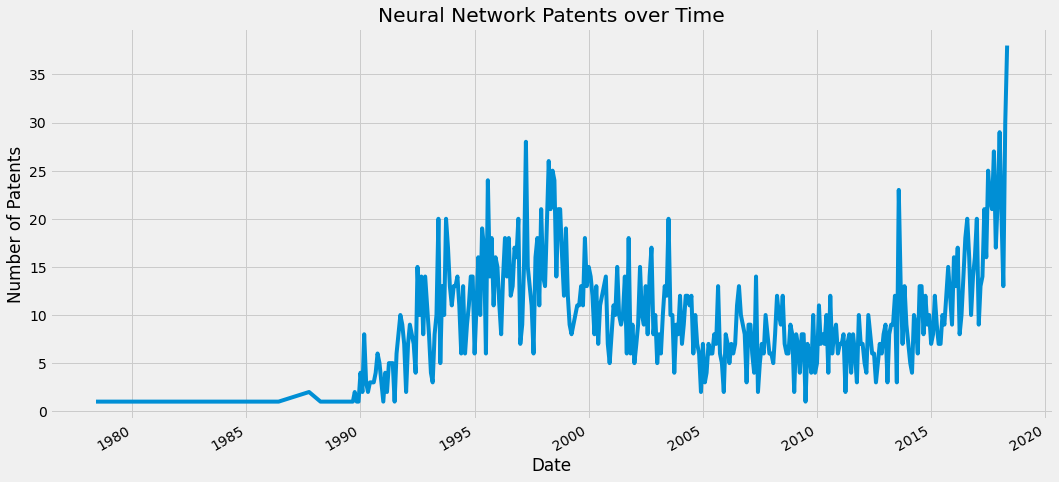

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

data['year-month'] = [
    pd.datetime(year, month, 1) for year, month in zip(
        data['patent_date'].dt.year, data['patent_date'].dt.month)
]

monthly = data.groupby('year-month')['patent_number'].count().reset_index()

monthly.set_index('year-month')['patent_number'].plot(figsize=(16, 8))
plt.ylabel('Number of Patents')
plt.xlabel('Date')
plt.title('Neural Network Patents over Time')

<AxesSubplot:xlabel='year-month'>

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Number of Patents')

Text(0.5, 1.0, 'Neural Network Patents by Year')

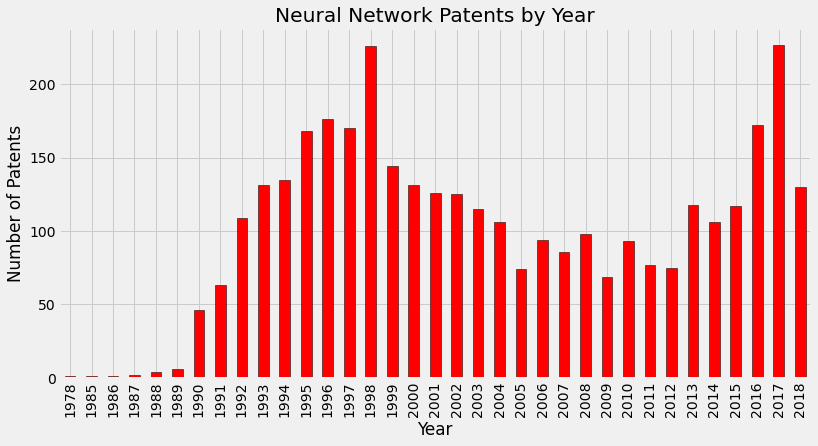

In [6]:
monthly.groupby(monthly['year-month'].dt.year)['patent_number'].sum().plot.bar(
    color='red', edgecolor='k', figsize=(12, 6))
plt.xlabel('Year')
plt.ylabel('Number of Patents')
plt.title('Neural Network Patents by Year')

The distribution of patents over time is interesting. I would expect 2018 to come out on top once the patents have been accepted. 

## Data Cleaning 

Our preprocessing is going to involve using a `Tokenizer` to convert the patents from sequences of words (strings) into sequences of integers. We'll get to that in a bit, but even with neural networks, having a clean dataset is paramount. The data quality is already high, but there are some idiosyncracies of patents as well as general text improvements to make. For example, let's consider the following two sentences.

>'This is a short sentence (1) with one reference to an image. This next sentence, while non-sensical, does not have an image and has two commas.'

If we choose to  remove all punctuation with the default Tokenizer settings, we get the following.

In [8]:
from keras.preprocessing.text import Tokenizer

example = 'This is a short sentence (1) with one reference to an image. This next sentence, while non-sensical, does not have an image and has two commas.'
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts([example])
s = tokenizer.texts_to_sequences([example])[0]
' '.join(tokenizer.index_word[i] for i in s)

ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`

This removes all the punctuation and now we have a random number in the sentence. If we choose to not remove the punctuation, the sentence looks better, but then we have some interesting words in the vocabulary.

In [8]:
tokenizer = Tokenizer(filters='"#$%&*+/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts([example])
s = tokenizer.texts_to_sequences([example])[0]
' '.join(tokenizer.index_word[i] for i in s)
tokenizer.word_index.keys()

'this is a short sentence (1) with one reference to an image. this next sentence, while non-sensical, does not have an image and has two commas.'

dict_keys(['this', 'an', 'is', 'a', 'short', 'sentence', '(1)', 'with', 'one', 'reference', 'to', 'image.', 'next', 'sentence,', 'while', 'non-sensical,', 'does', 'not', 'have', 'image', 'and', 'has', 'two', 'commas.'])

Notice that `image` and `image.` are classified as distinct words. This is because the period is attached to one and not the other and the same with `sentence` and `sentence,`. To alleviate this issue, we can add spaces around the punctuation using regular expressions. We will also remove the image references.

In [9]:
import re


def format_patent(patent):
    """Add spaces around punctuation and remove references to images/citations."""

    # Add spaces around punctuation
    patent = re.sub(r'(?<=[^\s0-9])(?=[.,;?])', r' ', patent)

    # Remove references to figures
    patent = re.sub(r'\((\d+)\)', r'', patent)

    # Remove double spaces
    patent = re.sub(r'\s\s', ' ', patent)
    return patent


f = format_patent(example)
f

'This is a short sentence with one reference to an image . This next sentence , while non-sensical , does not have an image and has two commas .'

Now when we do the tokenization, we get separate entries in the vocab for the punctuation, but _not_ for words with punctuation attached.

In [10]:
tokenizer = Tokenizer(filters='"#$%&*+/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts([f])
s = tokenizer.texts_to_sequences([f])[0]
' '.join(tokenizer.index_word[i] for i in s)
tokenizer.word_index.keys()

'this is a short sentence with one reference to an image . this next sentence , while non-sensical , does not have an image and has two commas .'

dict_keys(['this', 'sentence', 'an', 'image', '.', ',', 'is', 'a', 'short', 'with', 'one', 'reference', 'to', 'next', 'while', 'non-sensical', 'does', 'not', 'have', 'and', 'has', 'two', 'commas'])

We no longer have the `image` and `image.` problem but we do have separate symbols for `.` and `,`. This means the network will be forced to learn a representation for these punctuation marks (they are also in the pre-trained embeddings). When we want to get back to the original sentence (without image references) we simply have to remove the spaces.

In [11]:
def remove_spaces(patent):
    """Remove spaces around punctuation"""
    patent = re.sub(r'\s+([.,;?])', r'\1', patent)

    return patent


remove_spaces(' '.join(tokenizer.index_word[i] for i in s))

'this is a short sentence with one reference to an image. this next sentence, while non-sensical, does not have an image and has two commas.'

We can apply this operation to all of the original abstracts.

In [12]:
formatted = []

# Iterate through all the original abstracts
for a in original_abstracts:
    formatted.append(format_patent(a))

len(formatted)

3522

# Convert Text to Sequences

A neural network cannot process words, so we must convert the patent abstracts into integers. This is done using the Keras utility `Tokenizer`. By default, this will convert all words to lowercase and remove punctuation. Therefore, our model will not be able to write complete sentences. However, this can be beneficial for a first model because it limits the size of the vocabulary and means that more of the words (converted into tokens) will have pre-trained embeddings.

Later, we will not remove the capitalization and punctuation when we train our own embeddings.

## Features and Labels

This function takes a few parameters including a training length which is the number of words we will feed into the network as features with the next word the label. For example, if we set `training_length = 50`, then the model will take in 50 words as features and the 51st word as the label. 

For each abstract, we can make multiple training examples by slicing at different points. We can use the first 50 words as features with the 51st as a label, then the 2nd through 51st word as features and the 52nd as the label, then 3rd - 52nd with 53rd as label and so on. This gives us much more data to train on and the performance of the model is proportional to the amount of training data.

In [13]:
def make_sequences(texts,
                   training_length=50,
                   lower=True,
                   filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'):
    """Turn a set of texts into sequences of integers"""

    # Create the tokenizer object and train on texts
    tokenizer = Tokenizer(lower=lower, filters=filters)
    tokenizer.fit_on_texts(texts)

    # Create look-up dictionaries and reverse look-ups
    word_idx = tokenizer.word_index
    idx_word = tokenizer.index_word
    num_words = len(word_idx) + 1
    word_counts = tokenizer.word_counts

    print(f'There are {num_words} unique words.')

    # Convert text to sequences of integers
    sequences = tokenizer.texts_to_sequences(texts)

    # Limit to sequences with more than training length tokens
    seq_lengths = [len(x) for x in sequences]
    over_idx = [
        i for i, l in enumerate(seq_lengths) if l > (training_length + 20)
    ]

    new_texts = []
    new_sequences = []

    # Only keep sequences with more than training length tokens
    for i in over_idx:
        new_texts.append(texts[i])
        new_sequences.append(sequences[i])

    training_seq = []
    labels = []

    # Iterate through the sequences of tokens
    for seq in new_sequences:

        # Create multiple training examples from each sequence
        for i in range(training_length, len(seq)):
            # Extract the features and label
            extract = seq[i - training_length:i + 1]

            # Set the features and label
            training_seq.append(extract[:-1])
            labels.append(extract[-1])

    print(f'There are {len(training_seq)} training sequences.')

    # Return everything needed for setting up the model
    return word_idx, idx_word, num_words, word_counts, new_texts, new_sequences, training_seq, labels

Now let's see how our function generates data. For using pre-trained embeddings, we'll remove a fair amount of the punctuation and lowercase all letters but leave in periods and commas. This is because there are no capitalized words in the pre-trained embeddings but there is some punctuation. Our model will not learn how to capitalize words, but it may learn how to end a sentence and insert commas.

In [14]:
TRAINING_LEGNTH = 50
filters = '!"#$%&()*+/:<=>@[\\]^_`{|}~\t\n'
word_idx, idx_word, num_words, word_counts, abstracts, sequences, features, labels = make_sequences(
    formatted, TRAINING_LENGTH, lower=True, filters=filters)

There are 13677 unique words.
There are 320881 training sequences.


Each patent is now represented as a sequence of integers. Let's look at an example of a few features and the corresponding labels. The label is the next word in the sequence after the first 50 words.

In [15]:
n = 3
features[n][:10]

[3086, 1978, 11, 2, 9, 8, 19, 27, 5, 117]

In [16]:
def find_answer(index):
    """Find label corresponding to features for index in training data"""

    # Find features and label
    feats = ' '.join(idx_word[i] for i in features[index])
    answer = idx_word[labels[index]]

    print('Features:', feats)
    print('\nLabel: ', answer)

In [17]:
find_answer(n)

Features: enhances stability in a neural network system that , when used as a track-while-scan system , assigns sensor plots to predicted track positions in a plot track association situation . the barometer neuron functions as a bench-mark or reference system node that equates a superimposed plot and track to a

Label:  zero


In [18]:
original_abstracts[0]

'" A ""Barometer"" Neuron enhances stability in a Neural Network System that, when used as a track-while-scan system, assigns sensor plots to predicted track positions in a plot/track association situation. The ""Barometer"" Neuron functions as a bench-mark or reference system node that equates a superimposed plot and track to a zero distance as a ""perfect"" pairing of plot and track which has a measured/desired level of inhibition. The ""Barometer"" Neuron responds to the System inputs, compares these inputs against the level of inhibition of the ""perfect"" pair, and generates a supplied excitation or inhibition output signal to the System which adjusts the System to a desired value at or near 1.0; this the reference level of inhibition of the ""perfect"" pair. "'

In [19]:
find_answer(100)

Features: it comprises a novel hybrid architecture employing a binary synaptic array whose embodiment incorporates the fixed rules of the problem , such as the number of cities to be visited . the array is prompted by analog voltages representing variables such as distances . the processor incorporates two interconnected feedback

Label:  networks


Our patents are no longer correct English, but, by removing capital letters, we do reduce the size of the vocabulary. 

__Deciding which pre-processing steps to take in general is the most important aspect of an machine learning project.__

In [20]:
sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:15]

[('the', 36597),
 ('a', 24883),
 ('of', 20193),
 ('.', 16604),
 (',', 15417),
 ('and', 12947),
 ('to', 12073),
 ('network', 7733),
 ('neural', 7381),
 ('is', 7213),
 ('in', 6992),
 ('for', 6907),
 ('an', 6061),
 ('data', 4010),
 ('by', 3607)]

The most common words make sense in the context of the patents we are using and the geneal English language.

## Training Data

Next we need to take the features and labels and convert them into training and validation data. The following function does this by splitting the data - after random shuffling because the features were made in sequential order - based on the `train_fraction` specified. All the inputs are converted into numpy arrays which is the correct input to a keras neural network.

### Encoding of Labels

One important step is to convert the labels to one hot encoded vectors because our network will be trained using `categorical_crossentropy` and makes a prediction for each word in the vocabulary (we can train with the labels represented as simple integers, but I found performance was better and training faster when using a one-hot representation of the labels). This is done by creating an array of rows of all zeros except for the index of the word which we want to predict - the label - which gets a 1.

In [21]:
from sklearn.utils import shuffle


def create_train_valid(features,
                       labels,
                       num_words,
                       train_fraction=TRAIN_FRACTION):
    """Create training and validation features and labels."""

    # Randomly shuffle features and labels
    features, labels = shuffle(features, labels, random_state=RANDOM_STATE)

    # Decide on number of samples for training
    train_end = int(train_fraction * len(labels))

    train_features = np.array(features[:train_end])
    valid_features = np.array(features[train_end:])

    train_labels = labels[:train_end]
    valid_labels = labels[train_end:]

    # Convert to arrays
    X_train, X_valid = np.array(train_features), np.array(valid_features)

    # Using int8 for memory savings
    y_train = np.zeros((len(train_labels), num_words), dtype=np.int8)
    y_valid = np.zeros((len(valid_labels), num_words), dtype=np.int8)

    # One hot encoding of labels
    for example_index, word_index in enumerate(train_labels):
        y_train[example_index, word_index] = 1

    for example_index, word_index in enumerate(valid_labels):
        y_valid[example_index, word_index] = 1

    # Memory management
    import gc
    gc.enable()
    del features, labels, train_features, valid_features, train_labels, valid_labels
    gc.collect()

    return X_train, X_valid, y_train, y_valid

In [22]:
X_train, X_valid, y_train, y_valid = create_train_valid(
    features, labels, num_words)
X_train.shape
y_train.shape

(224616, 50)

(224616, 13677)

We do want to be careful about using up too much memory. One hot encoding the labels creates massive numpy arrays so I took care to delete the un-used objects from the workspace. 

In [23]:
import sys
sys.getsizeof(y_train) / 1e9

3.072073144

In [24]:
def check_sizes(gb_min=1):
    for x in globals():
        size = sys.getsizeof(eval(x)) / 1e9
        if size > gb_min:
            print(f'Object: {x:10}\tSize: {size} GB.')


check_sizes(gb_min=1)

Object: y_train   	Size: 3.072073144 GB.
Object: y_valid   	Size: 1.316616517 GB.


# Pre-Trained Embeddings

Rather than training our own word embeddings, a very expensive operation, we can use word embeddings that were trained on a large corpus of words. The hope is that these embeddings will generalize from the training corpus to our needs.

This code downloads 100-dimensional word embeddings if you don't already have them. There are a number of different pre-trained word embeddings you can find from [Stanford online](https://nlp.stanford.edu/data/).

In [25]:
import os
from keras.utils import get_file

# Vectors to use
glove_vectors = '/home/ubuntu/.keras/datasets/glove.6B.zip'

# Download word embeddings if they are not present
if not os.path.exists(glove_vectors):
    glove_vectors = get_file('glove.6B.zip',
                             'http://nlp.stanford.edu/data/glove.6B.zip')
    os.system(f'unzip {glove_vectors}')

# Load in unzipped file
glove_vectors = '/home/ubuntu/.keras/datasets/glove.6B.100d.txt'
glove = np.loadtxt(glove_vectors, dtype='str', comments=None)
glove.shape

(400000, 101)

Now we separated into the words and the vectors.

In [26]:
vectors = glove[:, 1:].astype('float')
words = glove[:, 0]

del glove

vectors[100], words[100]

(array([-3.9551e-01,  5.4660e-01,  5.0315e-01, -6.3682e-01, -4.5470e-01,
         3.0889e-01, -4.9240e-02,  2.7191e-01,  3.1562e-01, -3.2879e-01,
         2.5089e-01,  1.4508e-01,  3.5136e-01, -2.2793e-01, -1.5894e-01,
        -5.1527e-01, -2.7978e-01,  3.6470e-01, -3.9425e-01,  3.3299e-01,
         4.3051e-01,  1.8300e-01,  2.5095e-01, -1.8547e-01,  3.4698e-01,
         5.5137e-02, -4.5979e-01, -8.2963e-01, -1.8523e-02, -3.6772e-01,
         4.5566e-02,  7.1052e-01, -2.2782e-02, -8.0889e-02,  2.0685e-01,
         4.9855e-01, -5.9794e-02, -8.0048e-03, -2.3823e-01, -3.3759e-01,
        -2.4201e-01, -2.3788e-01, -1.1362e-03, -4.0395e-01, -4.4859e-01,
        -3.2189e-01,  4.8405e-01, -2.7999e-02,  1.0148e-01, -9.3585e-01,
        -8.7522e-02, -3.9959e-01,  3.6545e-01,  1.3726e+00, -3.0713e-01,
        -2.5940e+00,  2.2431e-01, -4.1168e-02,  1.7765e+00,  4.0010e-01,
        -1.0996e-01,  1.4178e+00, -2.6154e-01,  1.8617e-01,  7.9328e-01,
        -1.1709e-01,  8.7541e-01,  4.3911e-01,  3.4

Next we want to keep only those words that appear in our vocabulary. For words that are in our vocabulary but don't have an embedding, they will be represented as all 0s (a shortcoming that we can address by training our own embeddings.)

In [27]:
vectors.shape

(400000, 100)

In [28]:
word_lookup = {word: vector for word, vector in zip(words, vectors)}

embedding_matrix = np.zeros((num_words, vectors.shape[1]))

not_found = 0

for i, word in enumerate(word_idx.keys()):
    # Look up the word embedding
    vector = word_lookup.get(word, None)

    # Record in matrix
    if vector is not None:
        embedding_matrix[i + 1, :] = vector
    else:
        not_found += 1

print(f'There were {not_found} words without pre-trained embeddings.')

There were 2941 words without pre-trained embeddings.


In [29]:
import gc
gc.enable()
del vectors
gc.collect()

0

Each word is represented by 100 numbers with a number of words that can't be found. We can find the closest words to a given word in embedding space using the cosine distance. This requires first normalizing the vectors to have a magnitude of 1.

In [30]:
# Normalize and convert nan to 0
embedding_matrix = embedding_matrix / \
    np.linalg.norm(embedding_matrix, axis=1).reshape((-1, 1))
embedding_matrix = np.nan_to_num(embedding_matrix)

In [31]:
def find_closest(query, embedding_matrix, word_idx, idx_word, n=10):
    """Find closest words to a query word in embeddings"""

    idx = word_idx.get(query, None)
    # Handle case where query is not in vocab
    if idx is None:
        print(f'{query} not found in vocab.')
        return
    else:
        vec = embedding_matrix[idx]
        # Handle case where word doesn't have an embedding
        if np.all(vec == 0):
            print(f'{query} has no pre-trained embedding.')
            return
        else:
            # Calculate distance between vector and all others
            dists = np.dot(embedding_matrix, vec)

            # Sort indexes in reverse order
            idxs = np.argsort(dists)[::-1][:n]
            sorted_dists = dists[idxs]
            closest = [idx_word[i] for i in idxs]

    print(f'Query: {query}\n')
    max_len = max([len(i) for i in closest])
    # Print out the word and cosine distances
    for word, dist in zip(closest, sorted_dists):
        print(f'Word: {word:15} Cosine Similarity: {round(dist, 4)}')

In [32]:
find_closest('the', embedding_matrix, word_idx, idx_word)

Query: the

Word: the             Cosine Similarity: 1.0
Word: this            Cosine Similarity: 0.8573
Word: part            Cosine Similarity: 0.8508
Word: one             Cosine Similarity: 0.8503
Word: of              Cosine Similarity: 0.8329
Word: same            Cosine Similarity: 0.8325
Word: first           Cosine Similarity: 0.821
Word: on              Cosine Similarity: 0.82
Word: its             Cosine Similarity: 0.8169
Word: as              Cosine Similarity: 0.8128


In [33]:
find_closest('neural', embedding_matrix, word_idx, idx_word, 10)

Query: neural

Word: neural          Cosine Similarity: 1.0
Word: neuronal        Cosine Similarity: 0.6841
Word: cortical        Cosine Similarity: 0.676
Word: plasticity      Cosine Similarity: 0.6625
Word: pathways        Cosine Similarity: 0.6534
Word: neurons         Cosine Similarity: 0.6485
Word: sensory         Cosine Similarity: 0.6391
Word: cognitive       Cosine Similarity: 0.6125
Word: brain           Cosine Similarity: 0.6082
Word: physiological   Cosine Similarity: 0.6022


In [34]:
find_closest('.', embedding_matrix, word_idx, idx_word, 10)

Query: .

Word: .               Cosine Similarity: 1.0
Word: but             Cosine Similarity: 0.9049
Word: although        Cosine Similarity: 0.8812
Word: however         Cosine Similarity: 0.8778
Word: ,               Cosine Similarity: 0.8756
Word: when            Cosine Similarity: 0.8729
Word: and             Cosine Similarity: 0.8717
Word: though          Cosine Similarity: 0.8691
Word: it              Cosine Similarity: 0.8654
Word: this            Cosine Similarity: 0.8653


In [35]:
find_closest('wonder', embedding_matrix, word_idx, idx_word)

wonder not found in vocab.


In [36]:
find_closest('dnn', embedding_matrix, word_idx, idx_word)

dnn has no pre-trained embedding.


# Build Model

With data encoded as integers and an embedding matrix of pre-trained word vectors, we're ready to build the recurrent neural network. This model is relatively simple and uses an LSTM cell as the heart of the network. After converting the words into embeddings, we pass them through a single LSTM layer, then into a fully connected layer with `relu` activation before the final output layer with a `softmax` activation. The final layer produces a probability for every word in the vocab. 

When training, these predictions are compared to the actual label using the `categorical_crossentropy` to calculate a loss. The parameters (weights) in the network are then updated using the Adam optimizer (a variant on Stochastic Gradient Descent) with gradients calculated through backpropagation. Fortunately, Keras handles all of this behind the scenes, so we just have to set up the network and then start the training. The most difficult part is figuring out the correct shapes for the inputs and outputs into the model.

In [37]:
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam

from keras.utils import plot_model

In [38]:
def make_word_level_model(num_words,
                          embedding_matrix,
                          lstm_cells=64,
                          trainable=False,
                          lstm_layers=1,
                          bi_direc=False):
    """Make a word level recurrent neural network with option for pretrained embeddings
       and varying numbers of LSTM cell layers."""

    model = Sequential()

    # Map words to an embedding
    if not trainable:
        model.add(
            Embedding(
                input_dim=num_words,
                output_dim=embedding_matrix.shape[1],
                weights=[embedding_matrix],
                trainable=False,
                mask_zero=True))
        model.add(Masking())
    else:
        model.add(
            Embedding(
                input_dim=num_words,
                output_dim=embedding_matrix.shape[1],
                weights=[embedding_matrix],
                trainable=True))

    # If want to add multiple LSTM layers
    if lstm_layers > 1:
        for i in range(lstm_layers - 1):
            model.add(
                LSTM(
                    lstm_cells,
                    return_sequences=True,
                    dropout=0.1,
                    recurrent_dropout=0.1))

    # Add final LSTM cell layer
    if bi_direc:
        model.add(
            Bidirectional(
                LSTM(
                    lstm_cells,
                    return_sequences=False,
                    dropout=0.1,
                    recurrent_dropout=0.1)))
    else:
        model.add(
            LSTM(
                lstm_cells,
                return_sequences=False,
                dropout=0.1,
                recurrent_dropout=0.1))
    model.add(Dense(128, activation='relu'))
    # Dropout for regularization
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(num_words, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model


model = make_word_level_model(
    num_words,
    embedding_matrix=embedding_matrix,
    lstm_cells=LSTM_CELLS,
    trainable=False,
    lstm_layers=1)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1367700   
_________________________________________________________________
masking_1 (Masking)          (None, None, 100)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 13677)             1764333   
Total params: 3,182,593
Trainable params: 1,814,893
Non-trainable params: 1,367,700
__________________________________________________________

The model needs a loss to minimize (`categorical_crossentropy`) as well as a method for updating the weights using the gradients (`Adam`). We will also monitor accuracy which is not a good loss but can give us a more interpretable measure of the model performance.

Using pre-trained embeddings means we have about half the parameters to train. However, this also means that the embeddings might not be the best for our data, and there are a number of words with no embeddings.

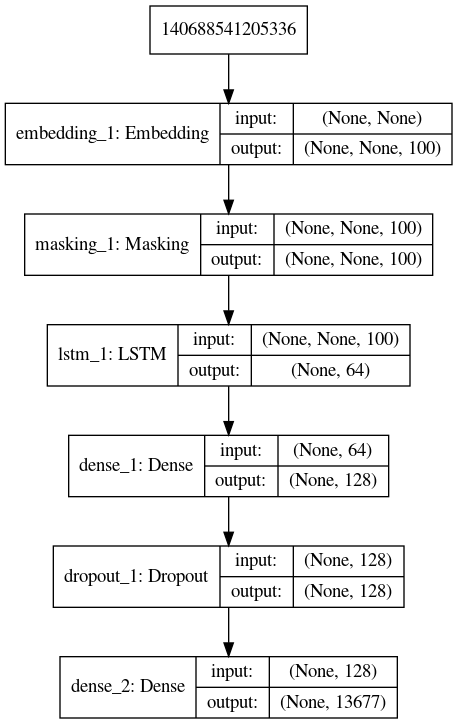

In [39]:
from IPython.display import Image
model_name = 'pre-trained-rnn'
model_dir = 'C:/Users/aruni/Desktop/McGill/Winter W2 Term/Intro to AI and DL/Individual_Project/rnn/'

plot_model(model, to_file=f'{model_dir}{model_name}.png', show_shapes=True)

Image(f'{model_dir}{model_name}.png')

# Train Model

We can now train the model on our training examples. We'll make sure to use early stopping with a validation set to stop the training when the loss on the validation set is no longer decreasing. Also, we'll save the best model every time the validation loss decreases so we can then load in the best model to generate predictions.

### Callbacks

* Early Stopping: Stop training when validation loss no longer decreases
* Model Checkpoint: Save the best model on disk

In [40]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

BATCH_SIZE = 2048


def make_callbacks(model_name, save=SAVE_MODEL):
    """Make list of callbacks for training"""
    callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

    if save:
        callbacks.append(
            ModelCheckpoint(
                f'{model_dir}{model_name}.h5',
                save_best_only=True,
                save_weights_only=False))
    return callbacks


callbacks = make_callbacks(model_name)

__Depending on your machine, this may take several hours to run.__

In [41]:
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
    callbacks=callbacks,
    validation_data=(X_valid, y_valid))

The accuracy - both training and validation - increase over time and the loss decreases over time which gives us indication that our model is getting better with training. 

We can load back in the model so we don't need to repeat the training.

In [42]:
def load_and_evaluate(model_name, return_model=False):
    """Load in a trained model and evaluate with log loss and accuracy"""

    model = load_model(f'{model_dir}{model_name}.h5')
    r = model.evaluate(X_valid, y_valid, batch_size=2048, verbose=1)

    valid_crossentropy = r[0]
    valid_accuracy = r[1]

    print(f'Cross Entropy: {round(valid_crossentropy, 4)}')
    print(f'Accuracy: {round(100 * valid_accuracy, 2)}%')

    if return_model:
        return model

In [43]:
model = load_and_evaluate(model_name, return_model=True)

96265/96265 [==============================] - 10s 100us/step
Cross Entropy: 4.7229
Accuracy: 23.9%


To check how the model compares to just using the word frequencies to make predictions, we can compute the accuracy if we were to use the most frequent word for every guess. We can also choose from a multinomial distribution using the word frequencies as probabilities.

In [44]:
np.random.seed(40)

# Number of all words
total_words = sum(word_counts.values())

# Compute frequency of each word in vocab
frequencies = [word_counts[word] / total_words for word in word_idx.keys()]
frequencies.insert(0, 0)

In [45]:
frequencies[1:10], list(word_idx.keys())[0:9]

([0.07345992492824023,
  0.049946807442943456,
  0.040532728477087054,
  0.03332864971195729,
  0.030946024609084886,
  0.025988076838154118,
  0.024233726088440155,
  0.015522190328990947,
  0.014815632589975713],
 ['the', 'a', 'of', '.', ',', 'and', 'to', 'network', 'neural'])

The most common word is 'the'. Let's see the accuracy of guessing this for every validation example.

In [46]:
print(
    f'The accuracy is {round(100 * np.mean(np.argmax(y_valid, axis = 1) == 1), 4)}%.'
)

The accuracy is 8.7207%.


Now we make a guess for each of the sequences in the validation set using the frequencies as probabilities. This is in some sense informed, but the multinomial also has randomness. 

In [47]:
random_guesses = []

# Make a prediction based on frequencies for each example in validation data
for i in range(len(y_valid)):
    random_guesses.append(
        np.argmax(np.random.multinomial(1, frequencies, size=1)[0]))

In [48]:
from collections import Counter

# Create a counter from the guesses
c = Counter(random_guesses)

# Iterate through the 10 most common guesses
for i in c.most_common(10):
    word = idx_word[i[0]]
    word_count = word_counts[word]
    print(
        f'Word: {word} \tCount: {word_count} \tPercentage: {round(100 * word_count / total_words, 2)}% \tPredicted: {i[1]}'
    )

Word: the 	Count: 36597 	Percentage: 7.35% 	Predicted: 7104
Word: a 	Count: 24883 	Percentage: 4.99% 	Predicted: 4829
Word: of 	Count: 20193 	Percentage: 4.05% 	Predicted: 3877
Word: . 	Count: 16604 	Percentage: 3.33% 	Predicted: 3292
Word: , 	Count: 15417 	Percentage: 3.09% 	Predicted: 2992
Word: and 	Count: 12947 	Percentage: 2.6% 	Predicted: 2464
Word: to 	Count: 12073 	Percentage: 2.42% 	Predicted: 2356
Word: network 	Count: 7733 	Percentage: 1.55% 	Predicted: 1463
Word: is 	Count: 7213 	Percentage: 1.45% 	Predicted: 1428
Word: in 	Count: 6992 	Percentage: 1.4% 	Predicted: 1384


In [49]:
accuracy = np.mean(random_guesses == np.argmax(y_valid, axis=1))
print(f'Random guessing accuracy: {100 * round(accuracy, 4)}%')

Random guessing accuracy: 1.63%


We can see that our model easily outperforms both guessing the most common word - 7.76% accuracy - as well as using relative word frequencies to guess the next word - 1.46% accuracy. Therefore, we can say that our model has learned something! 

# Generating Output

Now for the fun part: we get to use our model to generate new abstracts. To do this, we feed the network a seed sequence, have it make a prediction, add the predicted word to the sequence, and make another prediction for the next word. We continue this for the number of words that we want. We compare the generated output to the actual abstract to see if we can tell the difference!

In [50]:
from IPython.display import HTML


def header(text, color='black'):
    raw_html = f'<h1 style="color: {color};"><center>' + \
        str(text) + '</center></h1>'
    return raw_html


def box(text):
    raw_html = '<div style="border:1px inset black;padding:1em;font-size: 20px;">' + \
        str(text)+'</div>'
    return raw_html


def addContent(old_html, raw_html):
    old_html += raw_html
    return old_html

In [51]:
import random


def generate_output(model,
                    sequences,
                    training_length=50,
                    new_words=50,
                    diversity=1,
                    return_output=False,
                    n_gen=1):
    """Generate `new_words` words of output from a trained model and format into HTML."""

    # Choose a random sequence
    seq = random.choice(sequences)

    # Choose a random starting point
    seed_idx = random.randint(0, len(seq) - training_length - 10)
    # Ending index for seed
    end_idx = seed_idx + training_length

    gen_list = []

    for n in range(n_gen):
        # Extract the seed sequence
        seed = seq[seed_idx:end_idx]
        original_sequence = [idx_word[i] for i in seed]
        generated = seed[:] + ['#']

        # Find the actual entire sequence
        actual = generated[:] + seq[end_idx:end_idx + new_words]

        # Keep adding new words
        for i in range(new_words):

            # Make a prediction from the seed
            preds = model.predict(np.array(seed).reshape(1, -1))[0].astype(
                np.float64)

            # Diversify
            preds = np.log(preds) / diversity
            exp_preds = np.exp(preds)

            # Softmax
            preds = exp_preds / sum(exp_preds)

            # Choose the next word
            probas = np.random.multinomial(1, preds, 1)[0]

            next_idx = np.argmax(probas)

            # New seed adds on old word
            seed = seed[1:] + [next_idx]
            generated.append(next_idx)

        # Showing generated and actual abstract
        n = []

        for i in generated:
            n.append(idx_word.get(i, '< --- >'))

        gen_list.append(n)

    a = []

    for i in actual:
        a.append(idx_word.get(i, '< --- >'))

    a = a[training_length:]

    gen_list = [
        gen[training_length:training_length + len(a)] for gen in gen_list
    ]

    if return_output:
        return original_sequence, gen_list, a

    # HTML formatting
    seed_html = ''
    seed_html = addContent(seed_html, header(
        'Seed Sequence', color='darkblue'))
    seed_html = addContent(seed_html,
                           box(remove_spaces(' '.join(original_sequence))))

    gen_html = ''
    gen_html = addContent(gen_html, header('RNN Generated', color='darkred'))
    gen_html = addContent(gen_html, box(remove_spaces(' '.join(gen_list[0]))))

    a_html = ''
    a_html = addContent(a_html, header('Actual', color='darkgreen'))
    a_html = addContent(a_html, box(remove_spaces(' '.join(a))))

    return seed_html, gen_html, a_html

The `diversity` parameter determines how much randomness is added to the predictions. If we just use the most likely word for each prediction, the output sometimes gets stuck in loops. The diversity means the predicted text has a little more variation. 

In [52]:
seed_html, gen_html, a_html = generate_output(model, sequences,
                                              TRAINING_LENGTH)
HTML(seed_html)
HTML(gen_html)
HTML(a_html)

In [53]:
seed_html, gen_html, a_html = generate_output(
    model, sequences, TRAINING_LENGTH, diversity=1)
HTML(seed_html)
HTML(gen_html)
HTML(a_html)

In [54]:
seed_html, gen_html, a_html = generate_output(
    model, sequences, TRAINING_LENGTH, diversity=0.75)
HTML(seed_html)
HTML(gen_html)
HTML(a_html)

Increasing the diversity seems to increase the plausibility of the output. However, that could be becuase the patents themselves don't sound that realistic. This is especially true when we remove the punctuation. We'll fix that in the next section by keeping the punctuation and training our own embeddings.

# Training Own Embeddings

If we aren't happy with the output, especially the lack of punctuation, we can try training our own embeddings. This means the model will adapt the embeddings by itself to get better at the problem of predicting the next output. The final embeddings should place words that are more similar closer together in embedding space. The advantage of training our own embeddings are that they might be more relevant to the task. However, the downside is that training will take longer because the number of parameters significantly increases.

In [55]:
def clear_memory():
    import gc
    gc.enable()
    for i in [
            'model', 'X', 'y', 'word_idx', 'idx_word', 'X_train', 'X_valid,'
            'y_train', 'y_valid', 'embedding_matrix', 'words', 'vectors',
            'labels', 'random_guesses', 'training_seq', 'word_counts', 'data',
            'frequencies'
    ]:
        if i in dir():
            del globals()[i]
    gc.collect()


clear_memory()

Now when we create the training data, we do not remove the punctuation or convert the words to lowercase. 

In [56]:
TRAINING_LENGTH = 50

filters = '!"%;[\\]^_`{|}~\t\n'
word_idx, idx_word, num_words, word_counts, abstracts, sequences, features, labels = make_sequences(
    formatted, TRAINING_LENGTH, lower=False, filters=filters)

There are 16192 unique words.
There are 318563 training sequences.


In [57]:
embedding_matrix = np.zeros((num_words, len(word_lookup['the'])))

not_found = 0

for i, word in enumerate(word_idx.keys()):
    # Look up the word embedding
    vector = word_lookup.get(word, None)

    # Record in matrix
    if vector is not None:
        embedding_matrix[i + 1, :] = vector
    else:
        not_found += 1

print(f'There were {not_found} words without pre-trained embeddings.')
embedding_matrix.shape

There were 6317 words without pre-trained embeddings.


(16192, 100)

In [58]:
# Split into training and validation
X_train, X_valid, y_train, y_valid = create_train_valid(
    features, labels, num_words)
X_train.shape, y_train.shape

((222994, 50), (222994, 16192))

In [59]:
check_sizes(gb_min=1)

Object: y_train   	Size: 3.61071896 GB.
Object: y_valid   	Size: 1.54745336 GB.


Let's create a model with 100 dimensional embeddings, input sequences of length 50, and 1 LSTM layer as before.

In [60]:
model = make_word_level_model(
    num_words,
    embedding_matrix,
    lstm_cells=LSTM_CELLS,
    trainable=True,
    lstm_layers=1)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1619200   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16192)             2088768   
Total params: 3,758,528
Trainable params: 3,758,528
Non-trainable params: 0
_________________________________________________________________


In [61]:
model_name = 'train-embeddings-rnn'

callbacks = make_callbacks(model_name)

In [62]:
model.compile(
    optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=(X_valid, y_valid))

As before we load in the model and have it generate output.

In [63]:
model = load_and_evaluate(model_name, return_model=True)

95569/95569 [==============================] - 11s 110us/step
Cross Entropy: 4.7379
Accuracy: 26.72%


In [64]:
seed_html, gen_html, a_html = generate_output(
    model, sequences, TRAINING_LENGTH, diversity=0.75)
HTML(seed_html)
HTML(gen_html)
HTML(a_html)

In [65]:
seed_html, gen_html, a_html = generate_output(
    model, sequences, TRAINING_LENGTH, diversity=0.75)
HTML(seed_html)
HTML(gen_html)
HTML(a_html)

The most realisitic output seems to occur when the diversity is between 0.5 and 1.0. Sometimes it's difficult to tell the generated from the actual, a trial we'll look at a little later! 

## Inspect Embeddings

We can take a look at our trained embeddings to figure out the closest words in the embedding space. These embeddings are trained for our task, which means they may differ slightly from the pre-trained versions.

In [66]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1619200   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16192)             2088768   
Total params: 3,758,528
Trainable params: 3,758,528
Non-trainable params: 0
_________________________________________________________________


In [67]:
def get_embeddings(model):
    embedding_layer = model.get_layer(index=0)
    embedding_matrix = embedding_layer.get_weights()[0]
    embedding_matrix = embedding_matrix / \
        np.linalg.norm(embedding_matrix, axis=1).reshape((-1, 1))
    embedding_matrix = np.nan_to_num(embedding_matrix)
    return embedding_matrix


embedding_matrix = get_embeddings(model)
embedding_matrix.shape

(16192, 100)

In [68]:
find_closest('the', embedding_matrix, word_idx, idx_word)

Query: the

Word: the             Cosine Similarity: 1.0
Word: a               Cosine Similarity: 0.8156999945640564
Word: The             Cosine Similarity: 0.7764999866485596
Word: this            Cosine Similarity: 0.7674000263214111
Word: its             Cosine Similarity: 0.7583000063896179
Word: third           Cosine Similarity: 0.7434999942779541
Word: any             Cosine Similarity: 0.7361999750137329
Word: their           Cosine Similarity: 0.7300999760627747
Word: second          Cosine Similarity: 0.7290999889373779
Word: entire          Cosine Similarity: 0.7247999906539917


In [69]:
find_closest('neural', embedding_matrix, word_idx, idx_word)

Query: neural

Word: neural          Cosine Similarity: 1.0
Word: neuronal        Cosine Similarity: 0.6409000158309937
Word: Said            Cosine Similarity: 0.6399999856948853
Word: 3G              Cosine Similarity: 0.6276000142097473
Word: TCP/IP          Cosine Similarity: 0.6082000136375427
Word: Source          Cosine Similarity: 0.6029000282287598
Word: brain           Cosine Similarity: 0.566100001335144
Word: ARTMAP          Cosine Similarity: 0.5600000023841858
Word: search/sort     Cosine Similarity: 0.5591999888420105
Word: LTM             Cosine Similarity: 0.5540000200271606


In [70]:
find_closest('computer', embedding_matrix, word_idx, idx_word)

Query: computer

Word: computer        Cosine Similarity: 1.0
Word: software        Cosine Similarity: 0.7372999787330627
Word: technology      Cosine Similarity: 0.7092999815940857
Word: device          Cosine Similarity: 0.704800009727478
Word: computers       Cosine Similarity: 0.6647999882698059
Word: user            Cosine Similarity: 0.6610000133514404
Word: electronic      Cosine Similarity: 0.6514000296592712
Word: computing       Cosine Similarity: 0.6477000117301941
Word: web             Cosine Similarity: 0.6414999961853027
Word: database        Cosine Similarity: 0.629800021648407


# Change Parameters of Network

Next, we can try to generate more accurate predictions by altering the network parameters. To start, we will increase the number of LSTM layers to 2. The first LSTM layer returns the sequences - the entire output for each input sequence instead of only the final one - before passing it on to the second. Training may take a little longer, but performance could also improve. There's no guarantee this model is better because we could just end up overfitting on the training data.  

In [71]:
model = make_word_level_model(
    num_words,
    embedding_matrix,
    lstm_cells=LSTM_CELLS,
    trainable=True,
    lstm_layers=2)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         1619200   
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 64)          42240     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 16192)             2088768   
Total params: 3,791,552
Trainable params: 3,791,552
Non-trainable params: 0
_________________________________________________________________


In [72]:
model_name = 'train-embeddings-rnn-2-layers'

callbacks = make_callbacks(model_name)

history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=(X_valid, y_valid))

model = load_and_evaluate(model_name, return_model=True)
embedding_matrix = get_embeddings(model)

95569/95569 [==============================] - 12s 121us/step
Cross Entropy: 5.156
Accuracy: 23.19%


In [73]:
seed_html, gen_html, a_html = generate_output(
    model, sequences, TRAINING_LENGTH, diversity=0.75)
HTML(seed_html)
HTML(gen_html)
HTML(a_html)

## Use Bidirectional LSTM Layer

Another option is to use a bidirectional LSTM layer. This handles the input with one set of cells going from forward to backward and the other from backward to forward. This can sometimes help the model learn the relationship between sequences of words. The idea is that there is also structure moving from backward to forward.

In [74]:
model = make_word_level_model(
    num_words,
    embedding_matrix,
    lstm_cells=LSTM_CELLS,
    trainable=True,
    lstm_layers=1,
    bi_direc=True)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         1619200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 16192)             2088768   
Total params: 3,808,960
Trainable params: 3,808,960
Non-trainable params: 0
_________________________________________________________________


In [75]:
model_name = 'train-embeddings-rnn-bidirectional'

callbacks = make_callbacks(model_name)

history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=(X_valid, y_valid))

model = load_and_evaluate(model_name, return_model=True)
embedding_matrix = get_embeddings(model)

95569/95569 [==============================] - 12s 125us/step
Cross Entropy: 5.0348
Accuracy: 24.45%


In [76]:
seed_html, gen_html, a_html = generate_output(
    model, sequences, TRAINING_LENGTH, diversity=0.75)
HTML(seed_html)
HTML(gen_html)
HTML(a_html)

In [77]:
seed_html, gen_html, a_html = generate_output(
    model, sequences, TRAINING_LENGTH, diversity=0.75)
HTML(seed_html)
HTML(gen_html)
HTML(a_html)

# Change Training Length

Another option to try and improve the model is to change the length of the training sequences. The idea here is using more previous words will give the network more context for predicting the next word. However, it could also be that including more words _hurts_ the model because some of them are irrelevant! 

In [78]:
clear_memory()

In [79]:
TRAINING_LENGTH = 100

filters = '!"%;[\\]^_`{|}~\t\n'
word_idx, idx_word, num_words, word_counts, abstracts, sequences, features, labels = make_sequences(
    formatted, TRAINING_LENGTH, lower=False, filters=filters)

There are 16192 unique words.
There are 158579 training sequences.


In [80]:
X_train, X_valid, y_train, y_valid = create_train_valid(
    features, labels, num_words)
X_train.shape, y_train.shape

((111005, 100), (111005, 16192))

In [81]:
check_sizes()

Object: y_train   	Size: 1.797393072 GB.


In [82]:
model = make_word_level_model(
    num_words,
    embedding_matrix,
    lstm_cells=LSTM_CELLS,
    trainable=True,
    lstm_layers=1)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 100)         1619200   
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_9 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 16192)             2088768   
Total params: 3,758,528
Trainable params: 3,758,528
Non-trainable params: 0
_________________________________________________________________


In [83]:
model_name = 'train-embeddings-rnn-100-length'
callbacks = make_callbacks(model_name)

history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    callbacks=callbacks,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
    validation_data=(X_valid, y_valid))

model = load_and_evaluate(model_name, return_model=True)
embedding_matrix = get_embeddings(model)

47574/47574 [==============================] - 7s 138us/step
Cross Entropy: 5.1231
Accuracy: 24.31%


In [84]:
seed_html, gen_html, a_html = generate_output(
    model, sequences, TRAINING_LENGTH, diversity=1.5)
HTML(seed_html)
HTML(gen_html)
HTML(a_html)

# Reduce Training Length

In [85]:
clear_memory()
TRAINING_LENGTH = 20

filters = '!"%[\\]^_`{|}~\t\n'
word_idx, idx_word, num_words, word_counts, abstracts, sequences, features, labels = make_sequences(
    formatted, TRAINING_LENGTH, lower=False, filters=filters)

There are 16210 unique words.
There are 426028 training sequences.


In [86]:
embedding_matrix = np.zeros((num_words, len(word_lookup['the'])))

not_found = 0

for i, word in enumerate(word_idx.keys()):
    # Look up the word embedding
    vector = word_lookup.get(word, None)

    # Record in matrix
    if vector is not None:
        embedding_matrix[i + 1, :] = vector
    else:
        not_found += 1

print(f'There were {not_found} words without pre-trained embeddings.')

There were 6334 words without pre-trained embeddings.


In [87]:
X_train, X_valid, y_train, y_valid = create_train_valid(
    features, labels, num_words)
X_train.shape, y_train.shape

((298219, 20), (298219, 16210))

In [88]:
check_sizes()

Object: y_train   	Size: 4.834130102 GB.
Object: y_valid   	Size: 2.071784002 GB.


In [89]:
model = make_word_level_model(
    num_words,
    embedding_matrix,
    lstm_cells=LSTM_CELLS,
    trainable=True,
    lstm_layers=1,
    bi_direc=True)

model_name = 'train-embeddings-rnn-20-length'
callbacks = make_callbacks(model_name)

history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
    callbacks=callbacks,
    validation_data=(X_valid, y_valid))

model = load_and_evaluate(model_name, return_model=True)

127809/127809 [==============================] - 14s 108us/step
Cross Entropy: 4.59
Accuracy: 26.88%


In [90]:
seed_html, gen_html, a_html = generate_output(
    model, sequences, TRAINING_LENGTH, diversity=0.75)
HTML(seed_html)
HTML(gen_html)
HTML(a_html)

In [91]:
seed_html, gen_html, a_html = generate_output(
    model, sequences, TRAINING_LENGTH, diversity=0.8)
HTML(seed_html)
HTML(gen_html)
HTML(a_html)

# Is Output from a human or machine?

In [92]:
def guess_human(model, sequences, training_length=50, new_words=50):
    """Produce 2 RNN sequences and play game to compare to actaul.
       Diversity is randomly set between 0.5 and 1.25"""

    diversity = np.random.uniform(0.5, 1.25)
    sequence, gen_list, actual = generate_output(
        model,
        sequences,
        training_length,
        diversity=diversity,
        return_output=True,
        n_gen=2)
    gen_0, gen_1 = gen_list

    output = {
        'sequence': remove_spaces(' '.join(sequence)),
        'c0': remove_spaces(' '.join(gen_0)),
        'c1': remove_spaces(' '.join(gen_1)),
        'h': remove_spaces(' '.join(actual))
    }

    print(f"Seed Sequence: {output['sequence']}\n")

    choices = ['h', 'c0', 'c1']

    selected = []
    i = 0
    while len(selected) < 3:
        choice = random.choice(choices)
        selected.append(choice)
        print('\n')
        print(f'Option {i + 1} {output[choice]}')
        choices.remove(selected[-1])
        i += 1

    print('\n')
    guess = int(input('Enter option you think is human (1-3): ')) - 1
    print('\n')

    if guess == np.where(np.array(selected) == 'h')[0][0]:
        print('Correct')
        print('Correct Ordering', selected)
    else:
        print('Incorrect')
        print('Correct Ordering', selected)

    print('Diversity', round(diversity, 2))

In [93]:
guess_human(model, sequences)

Seed Sequence: then performed to provide optimized machining parameters for improved rate of material removal and tool life. Optionally, a two-stage artificial neural network may be supplementally employed, wherein a first stage of the network provides output parameters including peak tool temperature and cutting forces in X and Y



Option 1 < --- > contact fluid signals based on the filtered sensor. The neural network is instantiated domain for time depending on predetermined results from


Option 2 < --- > directions, for a combination of input reference parameters including tool rake angle, material cutting speed, and feed rate.


Option 3 < --- > voltage circuits having components from the spike signal, and perturbations corresponding to a similarity evaluation coefficient which is non-linearly differentiated.


Enter option you think is human (1-3): 2


Correct
Correct Ordering ['c1', 'h', 'c0']
Diversity 0.94


In [94]:
guess_human(model, sequences)

Seed Sequence: parameter configurations. The parameter configurations may include one or more of a variety of parameters, such as electrode configurations defining electrode combinations and polarities for an electrode set implanted in a patient. The electrode set may be carried by one or more implanted leads that are electrically



Option 1 < --- > coupled to the neurostimulator. In operation, the programming device executes a parameter configuration search algorithm to guide the clinician in the selection of parameter configurations. The search algorithm relies on a neural network that identifies potential optimum parameter configurations.


Option 2 < --- > evaluated in said magnetic plane. An neuron is therefore a structure for which each presents of the neural network element of the artificial neural network using a partial article, a laser transducer for neural network circuits and a programmable matrix so


Option 3 < --- > applied to the amplifiers, preferably not on a feedbac

# Conclusions

In this notebook, we saw how to build a recurrent neural network and used it to generate patent abstracts. Although the output is not always believable, this project gives us practice handling text sequences with neural networks. Deep learning has some advantages compared to traditional machine learning, especially in areas of computer vision and natural language processing. Hopefully you are now confident harnessing these powerful techniques to solve your own text problems! 

This project covered a number of steps for working with text data including:

1. Cleaning data using regular expressions
2. Preparing data for neural network
    * Converting text strings to integers (tokenization)
    * Encoding labels using one-hot encoding
    * Building training and validation set
3. Buildig a recurrent neural network using LSTM cells
4. Using pre-trained word embeddings and training our own embeddings
5. Adjusting model parameters to improve performance
6. Inspecting model results

The final results from the various models are below:

| Model Name                         | LSTM Layers | Bi-Directional | Training Length | Pre-Trained | Validation Log Loss | Validation Accuracy | Num Words in Vocab |
|------------------------------------|-------------|----------------|-----------------|-------------|---------------------|---------------------|--------------------|
| pre-trained-rnn                    | 1           | False          | 50              | True        | 4.7229              | 23.9                | 13677              |
| train-embeddings-rnn               | 1           | False          | 50              | False       | 4.7379              | 26.72               | 16192              |
| train-embeddings-rnn-2-layers      | 2           | False          | 50              | False       | 5.156               | 23.2                | 16192              |
| train-embeddings-rnn-bidirectional | 1           | True           | 50              | False       | 5.0348              | 24.5                | 16192              |
| train-embeddings-rnn-100-length    | 1           | False          | 100             | False       | 5.1231              | 24.3                | 16192              |
| train-embeddings-rnn-20-length     | 1           | True           | 20              | False       | 4.59                | 26.88               | 16210              |

The best performing model in terms of the validation data appears to be the model trained with sequences of length 20. This could be for a number of reasons such as the increased number of training sequences, or the fact that this network used a bi-directional layer. Overall, all of the models produced quite similar results suggesting their may be an upper limit in terms of the accuracy that can be achieved on this problem. I'd encourage anyone to tweak these parameters to see if performance can be improved! 

Although we didn't cover the theory in depth, we did see the implementation, which means we now have a framework to fit the concepts we study. Technical topics are best learned through practice, and this project gave us a great opportunity to explore the frontiers of natural language processing with deep learning.

# Appendix I: Training with A Data Generator

In [95]:
def data_gen(sequences, labels, batch_size, num_words):
    """Yield batches for training"""
    i = 0
    while True:

        # Reset once all examples have been used
        if i + batch_size > len(labels):
            i = 0

        X = np.array(sequences[i:i + batch_size])

        # Create array of zeros for labels
        y = np.zeros((BATCH_SIZE, num_words))
        # Extract integer labels
        ys = labels[i:i + batch_size]

        # Convert to one hot representation
        for example_num, word_num in enumerate(ys):
            y[example_num, word_num] = 1
        yield X, y

        i += batch_size
        gc.collect()


def create_train_valid_gen(features, labels, batch_size, num_words):
    """Create training and validation generators for training"""

    # Randomly shuffle features and labels
    features, labels = shuffle(features, labels, random_state=RANDOM_STATE)

    # Decide on number of samples for training
    train_end = int(0.7 * len(labels))

    train_features = np.array(features[:train_end])
    valid_features = np.array(features[train_end:])

    train_labels = labels[:train_end]
    valid_labels = labels[train_end:]

    # Make training and validation generators
    train_gen = data_gen(train_features, train_labels, batch_size, num_words)
    valid_gen = data_gen(valid_features, valid_labels, batch_size, num_words)

    return train_gen, valid_gen, train_end


BATCH_SIZE = 2048

train_gen, valid_gen, train_len = create_train_valid_gen(
    features, labels, BATCH_SIZE, num_words)
X, y = next(train_gen)

train_steps = train_len // BATCH_SIZE
valid_steps = (len(labels) - train_len) // BATCH_SIZE

X.shape
y.shape

train_steps
valid_steps

(2048, 20)

(2048, 16210)

145

62

In [96]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=train_steps,
    epochs=2,
    callbacks=None,
    validation_data=valid_gen,
    validation_steps=valid_steps)

Epoch 1/2
145/145 [==============================] - 174s 1s/step - loss: 3.7882 - acc: 0.2862 - val_loss: 4.5911 - val_acc: 0.2707
Epoch 2/2
145/145 [==============================] - 164s 1s/step - loss: 3.7672 - acc: 0.2879 - val_loss: 4.5872 - val_acc: 0.2712


# Appendix II: Using a Keras Sequence for Training

In [97]:
from keras.utils import Sequence


class textSequence(Sequence):
    """Keras Sequence for training with a generator."""

    def __init__(self, x_set, y_set, batch_size, num_words):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.num_words = num_words

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        X = np.array(batch_x)
        y = np.zeros((len(batch_y), self.num_words))

        for example_idx, word_idx in enumerate(batch_y):
            y[example_idx, word_idx] = 1

        return X, y

In [98]:
# Decide on number of samples for training
train_end = int(TRAIN_FRACTION * len(labels))

train_features = np.array(features[:train_end])
valid_features = np.array(features[train_end:])

train_labels = labels[:train_end]
valid_labels = labels[train_end:]

train_sequence = textSequence(train_features, train_labels, 2048, num_words)
valid_sequence = textSequence(valid_features, valid_labels, 2048, num_words)

In [99]:
history = model.fit_generator(
    train_sequence,
    epochs=2,
    callbacks=None,
    validation_data=valid_sequence,
    workers=20)

Epoch 1/2
146/146 [==============================] - 68s 465ms/step - loss: 4.1499 - acc: 0.2711 - val_loss: 3.7084 - val_acc: 0.3079
Epoch 2/2
146/146 [==============================] - 67s 458ms/step - loss: 4.0915 - acc: 0.2743 - val_loss: 3.7551 - val_acc: 0.3025
